### 1. Import Modules, Dataset, Transform, Dataloader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Zip Files from Server

In [ ]:
import zipfile
import os
import shutil

def unzip_and_count(dataset, dst_path):
    with zipfile.ZipFile(dataset, 'r') as file:
        # Create a directory with the same name as the zip file (without extension) to extract files into it
        extract_dir = os.path.join(dst_path, os.path.splitext(os.path.basename(dataset))[0])

        # Create the directory if it doesn't exist
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)

        # Extract all contents into the created directory
        file.extractall(extract_dir)

    # Print the count of images
    print(f'total images in {os.path.basename(dataset)}:', len(os.listdir(extract_dir)))

# zip files들 경로 지정
datasets = {
    'realimage_crop.zip': '/content/drive/MyDrive/GAN/CartoonGAN/images/realimage_crop.zip',
    'cartoon_crop_image.zip': '/content/drive/MyDrive/GAN/CartoonGAN/images/cartoon_crop_image.zip',
    'cartoon_crop_smooth_image.zip': '/content/drive/MyDrive/GAN/CartoonGAN/images/cartoon_crop_smooth_image.zip'
}

# Destination directory
dst_path = '/content/images'

# Unzip and count images for each dataset
for name, path in datasets.items():
    unzip_and_count(path, dst_path)



total images in realimage_crop.zip: 1
total images in cartoon_crop_image.zip: 1
total images in cartoon_crop_smooth_image.zip: 1


In [ ]:
crop_image = os.path.join(dst_path,'cartoon_crop_image/cartoon_crop_image')
print('total  images:', len(os.listdir(crop_image)))

smooth = os.path.join(dst_path,'cartoon_crop_smooth_image/cartoon_crop_smooth_image')
print('total  images:', len(os.listdir(smooth)))

real = os.path.join(dst_path,'realimage_crop/cropped_images')
print('total  images:', len(os.listdir(real)))

total  images: 9782
total  images: 9782
total  images: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import gc
from tqdm import tqdm

In [ ]:
class ImageDataset(Dataset):  # pytorch 의 Dataset 함수 상속받음

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # 이미지 파일들이 저장된 디렉토리의 경로
        self.root_files = os.listdir(root_dir) # root_dir 안에 있는 모든 파일들의 목록들을 저장
        self.transform = transform

    def __len__(self):
        return len(self.root_files) # root_files 에 있는 파일들의 갯수

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.root_files[idx])
        img = Image.open(img_path).convert('RGB') # 'RGB'로 변환을 강제함
        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
def get_default_transforms(size=256):
    return transforms.Compose([
        transforms.Resize(size=size),
        transforms.CenterCrop(size=size),
        transforms.RandomHorizontalFlip(p=.5), # 이미지를 50% 확률로 좌우 반전시킴
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_no_aug_transform(size=256):
    return transforms.Compose([
        # transforms.Resize(size=size),
        # transforms.CenterCrop(size=size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_pair_transforms(size=256, flip=.01):
    return transforms.Compose([
        # transforms.Resize(size=size),
        # transforms.RandomHorizontalFlip(p=flip),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


In [ ]:
real_data_path = '/content/images/realimage_crop/cropped_images'
cartoon_data_path = (
    '/content/images/cartoon_crop_image/cartoon_crop_image'
)
cartoon_smoothed_data_path = (
    '/content/images/cartoon_crop_smooth_image/cartoon_crop_smooth_image'
)
save_pretrained_path = (
   ' /content/drive/MyDrive/cartoongan/pretrain_images'
)
save_pretrained_checkpoints = "/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/pretrain_G"




def get_dataloader(path, size=256, batch_size=64, transforms=None, flip=0.005):
    "If no transform is given, a default one is used"

    if not transforms:
        transforms = get_default_transforms(size=size)
    dataset = ImageDataset(path, transform=transforms)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,#True 일경우 마지막 배치가 batch_size보다 작을 경우 그 배치를 버림
        num_workers=0,
        # multiprocessing_context="fork",
    )

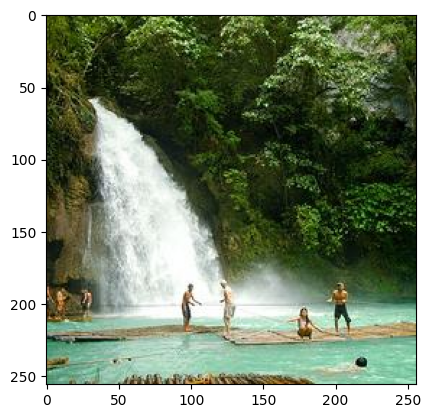

In [ ]:
def unnormalize(tensor):
    # 평균과 표준편차로 정규화된 텐서를 다시 원래 범위로 변환
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return tensor

# ImageDataset에서 이미지 로드
image_tensor = ImageDataset(real_data_path, transform=get_no_aug_transform())[1244]

# 정규화 해제
image_np = unnormalize(image_tensor).permute(1, 2, 0).numpy()  # CHW -> HWC 변환

# 이미지 시각화
plt.imshow(image_np)
plt.show()


In [ ]:
# import os

# def rename_images(directory):
#     # 디렉토리에서 모든 파일을 불러온다
#     files = os.listdir(directory)
#     # 파일 이름을 정렬한다 (선택적)
#     files.sort()
#     # 파일 이름 변경
#     for i, filename in enumerate(files, 1):
#         # 파일의 확장자를 유지하기 위해 분리
#         ext = os.path.splitext(filename)[1]
#         # 새 파일 이름 생성
#         new_filename = f"{i}{ext}"
#         # 파일 이름 변경 실행
#         os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
#         print(f"{filename} -> {new_filename}")

### 2. Layers

In [ ]:
def conv_3x3(in_channels, out_channels, stride=1):
    """
    3 x 3 convolution w/ reflection padding

    (3, 1, 1) convolution with mirror padding 으로 해석하면 됨
    """
    return nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=0,
            bias=False,
        ),
    )

In [ ]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv_3x3(n_channels, n_channels, stride=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(inplace=True),
            conv_3x3(n_channels, n_channels, stride=1),
            nn.BatchNorm2d(n_channels),
        )
        self.relu = nn.ReLU(inplace=True)

        initialize_weights(self)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
def add_resblocks(n_channels, n_blocks):
    return nn.Sequential(*[ResBlock(n_channels) for _ in range(n_blocks)])

In [ ]:
class Upblock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, add_blur=False):
        super(Upblock, self).__init__()

        self.shuffle = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=0,
            bias=False,
        )
        """
        (3, 2, 0): 3x3 convolution with stride 2 and 0 padding

        output_size = (2 * input_size) + 1

        """

        self.has_blur = add_blur
        if add_blur:
            self.blur = nn.AvgPool2d(2, 1)

        """
        AvgPool2d(kernel_size=2, stride=1, padding=0)

        output_size = (((2 * input_size) + 1) - 2 / 1) + 1 = 2 * input_size

        """

    def forward(self, x):
        x = self.shuffle(x)
        if self.has_blur:
            x = self.blur(x)
        return x

### 3. Helpers

In [ ]:
def unnormalize(t):
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(t.device)
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(t.device)
    return t * std + mean

In [ ]:
# def unnormalize(t):
#     mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).reshape(1, 3, 1, 1).to(t.device)
#     std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).reshape(1, 3, 1, 1).to(t.device)
#     return t * std + mean

### 4. Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            # Flat Block(1)
            conv_3x3(3, 32, stride=1), # 32 x 256 x 256
            nn.LeakyReLU(0.2, inplace=True),

            # Down Block(2)
            conv_3x3(32, 64, stride=2), # 64 x 128 x 128
            nn.LeakyReLU(0.2, inplace=True),
            conv_3x3(64, 128, stride=1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            conv_3x3(128, 128, stride=2), # 128 x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            conv_3x3(128, 256, stride=1), # 256 x 64 x 64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Feature construction block(1)
            conv_3x3(256, 256, stride=1), # 256 x 64 x 64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Final Convolution(1)
            conv_3x3(256, 1, stride=1), # 1 x 64 x 64
            nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, x):
        return self.layers(x)

### 5. Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            # Flat Block(1)
            nn.Conv2d(
                3, 64, kernel_size=7, stride=1, padding=7 // 2, bias=False
            ),  # 64 x 256 x 256 (size 유지)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Down Block(2)
            conv_3x3(64, 128, stride=2), # 128 x 128 x 128
            conv_3x3(128, 128, stride=1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            conv_3x3(128, 256, stride=2), # 256 x 64 x 64
            conv_3x3(256, 256, stride=1), # 256 x 64 x 64
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual Block(8)
            add_resblocks(256, 8), # 256 x 64 x 64

            # Up Block(2)
            Upblock(256, 128, stride=2, add_blur=True), # 128 x 128 x 128
            conv_3x3(128, 128, stride=1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            Upblock(128, 64, stride=2, add_blur=True), # 64 x 256 x 256
            conv_3x3(64, 64, stride=1), # 64 x 256 x 256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Final Convolution(1)
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=7 // 2, bias=False), # 3 x 256 x 256 (size 유지)
        )

        initialize_weights(self)

    def forward(self, x):
        return self.layers(x)


### 6. Pre - Training (Only G)

처음에 Generator 학습시키기 ( Content 학습시키기 )
- vgg ( 31번쨰 layer 까지 있는데 24번째 layer 까지만 가져오고 )
- vgg 를 통과한 real_image 와 generator 가 real image 를 참고하여 만든 generator image 를 손실함수에 넣어 generator 를 train 시킴


In [ ]:
#pretrain된 vgg16 의 feature layers 를 list 로 나타냄
list(vgg16(pretrained=True).features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.8MB/s]


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [ ]:
print(len(list(vgg16(pretrained=True).features)), sep="\n")
list(vgg16(pretrained=True).features)[:25]

31


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, omega=10):
        super(ContentLoss, self).__init__()

        self.base_loss = nn.L1Loss()
        self.omega = omega

        perception = list(vgg16(pretrained=True).features)[:25]
        self.perception = nn.Sequential(*perception).eval() # sequential module로 변환하고, 평가모드로

        for param in self.perception.parameters():
            param.requires_grad = False # 학습 중에 업데이트 되지 않도록

        gc.collect()

    def forward(self, x, y):
        x = self.perception(x) # ex) vgg를 통과한 real_images feature map
        y = self.perception(y) # ex) vgg를 통과한 generated_images feature map

        return self.base_loss(x, y) * self.omega

In [ ]:
def pretrain():
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # Configurations
    batch_size = 16
    image_size = 256
    learning_rate = 1e-3
    betas = (0.5, 0.999)
    weight_decay = 1e-3
    n_epochs = 10

    # Data Loaders
    pretrain_data_loader = get_dataloader(
        path=real_data_path,
        size=image_size,
        batch_size=batch_size,
        transforms=get_no_aug_transform(),  # No Augmentation (No resize, No flip)
    )

    # List to keep track of progress
    G_losses = []
    iteration = 0

    # Retrieve and process the first batch of images
    # tracked_images = next(iter(pretrain_data_loader)).to(device)
    tracked_images = ImageDataset(real_data_path, transform=get_no_aug_transform())[0]

    # DataLoader의 이미지 중 하나를 시각화
    img_np = tracked_images.permute(1, 2, 0).numpy()  # CHW to HWC
    img_np = np.clip(img_np, 0, 1)  # 데이터를 [0, 1] 범위로 제한
    print(img_np.shape)
    plt.imshow(img_np)
    plt.show()

    tracked_images = tracked_images.unsqueeze(0)# (C, H, W) -> (1,C,H,W) 배치차원 추가
    tracked_images = tracked_images.to(device)

    torchvision.utils.save_image(
        unnormalize(tracked_images),
        "/content/drive/MyDrive/GAN/CartoonGAN/pretain_image",
        padding=2,
        normalize=True,
        scale_each=True,
    )

    # Models
    G = Generator().to(device)
    optimizer = optim.AdamW(
        G.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay
    )
    content_loss = ContentLoss().to(device)

    print("Starting Training Loop...")

    # For each epoch
    for epoch in range(n_epochs):
        # For each batch in the dataloader
        for i, real_images in enumerate(
            tqdm(pretrain_data_loader, desc=f"Training Epoch {epoch}")
        ):

            ############################
            # (1) Pre-train G
            ###########################

            # Move to device
            real_images = real_images.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Generate fake images
            generated_images = G(real_images)
            loss = content_loss(real_images, generated_images)

            # Backpropagate
            loss.backward()

            # Update weights
            optimizer.step()

            # --------------------------------------------------------------------------------------------------- #

            # Save the loss
            G_losses.append(loss.item())

            if iteration % 100 == 0:

                with torch.no_grad():
                    fake_images = G(tracked_images).detach().cpu()
                print(f"Epoch: {epoch}, Iteration: {iteration}, Loss: {loss.item()}")
                torchvision.utils.save_image(
                    unnormalize(fake_images),
                    f"/content/drive/MyDrive/GAN/CartoonGAN/pretain_image{epoch}_{i}.png",
                    padding=2,
                    scale_each=True,
                )
                torch.save(
                    G.state_dict(),
                    os.path.join(
                        save_pretrained_checkpoints,
                        f"epoch{epoch}_iter{iteration}_loss{loss.item():.3f}.pth",
                    ),
                )

            iteration += 1

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    torch.save(
        G.state_dict(),
        f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/pretrain_G/epoch{epoch}_iter{iteration}_loss{loss.item():.3f}.pth",
    )

cuda
(256, 256, 3)


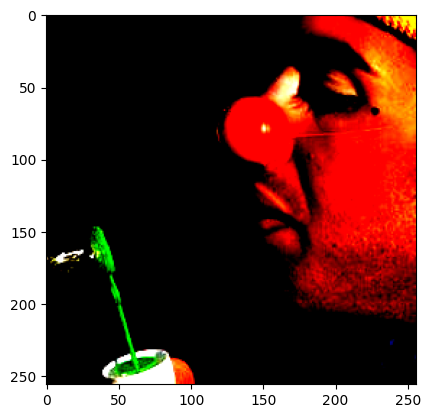

Starting Training Loop...


Training Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 0, Iteration: 0, Loss: 55.448760986328125


Training Epoch 0:  16%|█▌        | 101/625 [08:35<13:23,  1.53s/it]

Epoch: 0, Iteration: 100, Loss: 34.03832244873047


Training Epoch 0:  32%|███▏      | 201/625 [11:03<10:51,  1.54s/it]

Epoch: 0, Iteration: 200, Loss: 28.798389434814453


Training Epoch 0:  48%|████▊     | 301/625 [13:32<08:22,  1.55s/it]

Epoch: 0, Iteration: 300, Loss: 27.289466857910156


Training Epoch 0:  64%|██████▍   | 401/625 [16:01<05:48,  1.56s/it]

Epoch: 0, Iteration: 400, Loss: 25.451929092407227


Training Epoch 0:  80%|████████  | 500/625 [18:28<03:05,  1.48s/it]

Epoch: 0, Iteration: 500, Loss: 22.816946029663086


Training Epoch 0:  96%|█████████▌| 600/625 [20:56<00:36,  1.48s/it]

Epoch: 0, Iteration: 600, Loss: 25.135501861572266


Training Epoch 0: 100%|██████████| 625/625 [21:34<00:00,  2.07s/it]


Epoch: 0, Loss: 22.636749267578125


Training Epoch 1:  12%|█▏        | 76/625 [01:53<13:59,  1.53s/it]

Epoch: 1, Iteration: 700, Loss: 20.78485679626465


Training Epoch 1:  28%|██▊       | 176/625 [04:21<11:32,  1.54s/it]

Epoch: 1, Iteration: 800, Loss: 22.683979034423828


Training Epoch 1:  44%|████▍     | 276/625 [06:50<09:00,  1.55s/it]

Epoch: 1, Iteration: 900, Loss: 24.645652770996094


Training Epoch 1:  60%|██████    | 376/625 [09:19<06:25,  1.55s/it]

Epoch: 1, Iteration: 1000, Loss: 23.467697143554688


Training Epoch 1:  76%|███████▌  | 475/625 [11:46<03:42,  1.48s/it]

Epoch: 1, Iteration: 1100, Loss: 18.603782653808594


Training Epoch 1:  92%|█████████▏| 576/625 [14:17<01:15,  1.55s/it]

Epoch: 1, Iteration: 1200, Loss: 18.985271453857422


Training Epoch 1: 100%|██████████| 625/625 [15:30<00:00,  1.49s/it]


Epoch: 1, Loss: 18.448814392089844


Training Epoch 2:   8%|▊         | 51/625 [01:15<14:45,  1.54s/it]

Epoch: 2, Iteration: 1300, Loss: 17.079608917236328


Training Epoch 2:  24%|██▍       | 151/625 [03:44<12:14,  1.55s/it]

Epoch: 2, Iteration: 1400, Loss: 17.624679565429688


Training Epoch 2:  40%|████      | 251/625 [06:14<09:39,  1.55s/it]

Epoch: 2, Iteration: 1500, Loss: 17.239229202270508


Training Epoch 2:  56%|█████▌    | 351/625 [08:43<07:04,  1.55s/it]

Epoch: 2, Iteration: 1600, Loss: 16.053279876708984


Training Epoch 2:  72%|███████▏  | 450/625 [11:10<04:19,  1.48s/it]

Epoch: 2, Iteration: 1700, Loss: 15.833907127380371


Training Epoch 2:  88%|████████▊ | 551/625 [13:40<01:54,  1.54s/it]

Epoch: 2, Iteration: 1800, Loss: 14.323712348937988


Training Epoch 2: 100%|██████████| 625/625 [15:30<00:00,  1.49s/it]


Epoch: 2, Loss: 15.99937915802002


Training Epoch 3:   4%|▍         | 26/625 [00:38<15:21,  1.54s/it]

Epoch: 3, Iteration: 1900, Loss: 15.397651672363281


Training Epoch 3:  20%|██        | 126/625 [03:07<12:51,  1.55s/it]

Epoch: 3, Iteration: 2000, Loss: 14.282575607299805


Training Epoch 3:  36%|███▌      | 226/625 [05:36<10:16,  1.55s/it]

Epoch: 3, Iteration: 2100, Loss: 13.001701354980469


Training Epoch 3:  52%|█████▏    | 325/625 [08:02<07:26,  1.49s/it]

Epoch: 3, Iteration: 2200, Loss: 14.455511093139648


Training Epoch 3:  68%|██████▊   | 426/625 [10:33<05:10,  1.56s/it]

Epoch: 3, Iteration: 2300, Loss: 14.423391342163086


Training Epoch 3:  84%|████████▍ | 526/625 [13:02<02:33,  1.55s/it]

Epoch: 3, Iteration: 2400, Loss: 14.368459701538086


Training Epoch 3: 100%|██████████| 625/625 [15:29<00:00,  1.49s/it]


Epoch: 3, Loss: 12.480583190917969


Training Epoch 4:   0%|          | 1/625 [00:01<17:30,  1.68s/it]

Epoch: 4, Iteration: 2500, Loss: 12.973581314086914


Training Epoch 4:  16%|█▌        | 101/625 [02:30<13:29,  1.55s/it]

Epoch: 4, Iteration: 2600, Loss: 13.885984420776367


Training Epoch 4:  32%|███▏      | 201/625 [04:59<10:58,  1.55s/it]

Epoch: 4, Iteration: 2700, Loss: 12.1659517288208


Training Epoch 4:  48%|████▊     | 300/625 [07:26<08:05,  1.49s/it]

Epoch: 4, Iteration: 2800, Loss: 10.801752090454102


Training Epoch 4:  64%|██████▍   | 400/625 [09:55<05:31,  1.47s/it]

Epoch: 4, Iteration: 2900, Loss: 12.150301933288574


Training Epoch 4:  80%|████████  | 501/625 [12:25<03:11,  1.54s/it]

Epoch: 4, Iteration: 3000, Loss: 11.355090141296387


Training Epoch 4:  96%|█████████▌| 601/625 [14:53<00:37,  1.56s/it]

Epoch: 4, Iteration: 3100, Loss: 11.001274108886719


Training Epoch 4: 100%|██████████| 625/625 [15:29<00:00,  1.49s/it]


Epoch: 4, Loss: 11.282825469970703


Training Epoch 5:  12%|█▏        | 76/625 [01:53<14:11,  1.55s/it]

Epoch: 5, Iteration: 3200, Loss: 11.49874210357666


Training Epoch 5:  28%|██▊       | 175/625 [04:20<11:03,  1.47s/it]

Epoch: 5, Iteration: 3300, Loss: 12.521583557128906


Training Epoch 5:  44%|████▍     | 275/625 [06:48<08:40,  1.49s/it]

Epoch: 5, Iteration: 3400, Loss: 10.303117752075195


Training Epoch 5:  60%|██████    | 375/625 [09:16<06:10,  1.48s/it]

Epoch: 5, Iteration: 3500, Loss: 14.931562423706055


Training Epoch 5:  76%|███████▌  | 476/625 [11:46<03:49,  1.54s/it]

Epoch: 5, Iteration: 3600, Loss: 11.007932662963867


Training Epoch 5:  92%|█████████▏| 575/625 [14:13<01:14,  1.49s/it]

Epoch: 5, Iteration: 3700, Loss: 10.65887451171875


Training Epoch 5: 100%|██████████| 625/625 [15:28<00:00,  1.49s/it]


Epoch: 5, Loss: 11.56986141204834


Training Epoch 6:   8%|▊         | 50/625 [01:14<14:09,  1.48s/it]

Epoch: 6, Iteration: 3800, Loss: 10.88804817199707


Training Epoch 6:  24%|██▍       | 151/625 [03:44<12:09,  1.54s/it]

Epoch: 6, Iteration: 3900, Loss: 11.684104919433594


Training Epoch 6:  40%|████      | 251/625 [06:12<09:36,  1.54s/it]

Epoch: 6, Iteration: 4000, Loss: 10.134221076965332


Training Epoch 6:  56%|█████▌    | 351/625 [08:41<07:04,  1.55s/it]

Epoch: 6, Iteration: 4100, Loss: 9.335967063903809


Training Epoch 6:  72%|███████▏  | 450/625 [11:08<04:20,  1.49s/it]

Epoch: 6, Iteration: 4200, Loss: 10.27639389038086


Training Epoch 6:  88%|████████▊ | 551/625 [13:39<01:54,  1.55s/it]

Epoch: 6, Iteration: 4300, Loss: 11.351500511169434


Training Epoch 6: 100%|██████████| 625/625 [15:28<00:00,  1.49s/it]


Epoch: 6, Loss: 9.900840759277344


Training Epoch 7:   4%|▍         | 26/625 [00:38<15:27,  1.55s/it]

Epoch: 7, Iteration: 4400, Loss: 9.635080337524414


Training Epoch 7:  20%|██        | 126/625 [03:07<12:54,  1.55s/it]

Epoch: 7, Iteration: 4500, Loss: 11.382527351379395


Training Epoch 7:  36%|███▌      | 225/625 [05:34<09:49,  1.47s/it]

Epoch: 7, Iteration: 4600, Loss: 10.068090438842773


Training Epoch 7:  52%|█████▏    | 326/625 [08:05<07:41,  1.54s/it]

Epoch: 7, Iteration: 4700, Loss: 10.62086009979248


Training Epoch 7:  68%|██████▊   | 426/625 [10:33<05:08,  1.55s/it]

Epoch: 7, Iteration: 4800, Loss: 9.466520309448242


Training Epoch 7:  84%|████████▍ | 526/625 [13:02<02:33,  1.55s/it]

Epoch: 7, Iteration: 4900, Loss: 9.710077285766602


Training Epoch 7: 100%|██████████| 625/625 [15:29<00:00,  1.49s/it]


Epoch: 7, Loss: 9.405567169189453


Training Epoch 8:   0%|          | 1/625 [00:01<17:20,  1.67s/it]

Epoch: 8, Iteration: 5000, Loss: 8.980060577392578


Training Epoch 8:  16%|█▌        | 100/625 [02:28<12:53,  1.47s/it]

Epoch: 8, Iteration: 5100, Loss: 10.13429069519043


Training Epoch 8:  32%|███▏      | 200/625 [04:56<10:24,  1.47s/it]

Epoch: 8, Iteration: 5200, Loss: 9.613380432128906


Training Epoch 8:  48%|████▊     | 301/625 [07:26<08:21,  1.55s/it]

Epoch: 8, Iteration: 5300, Loss: 8.209320068359375


Training Epoch 8:  64%|██████▍   | 401/625 [09:55<05:47,  1.55s/it]

Epoch: 8, Iteration: 5400, Loss: 9.06493091583252


Training Epoch 8:  80%|████████  | 500/625 [12:22<03:05,  1.48s/it]

Epoch: 8, Iteration: 5500, Loss: 8.859107971191406


Training Epoch 8:  96%|█████████▌| 601/625 [14:52<00:37,  1.54s/it]

Epoch: 8, Iteration: 5600, Loss: 10.460201263427734


Training Epoch 8: 100%|██████████| 625/625 [15:28<00:00,  1.48s/it]


Epoch: 8, Loss: 9.874723434448242


Training Epoch 9:  12%|█▏        | 75/625 [01:51<13:31,  1.48s/it]

Epoch: 9, Iteration: 5700, Loss: 9.009005546569824


Training Epoch 9:  28%|██▊       | 176/625 [04:21<11:29,  1.54s/it]

Epoch: 9, Iteration: 5800, Loss: 9.45547866821289


Training Epoch 9:  44%|████▍     | 276/625 [06:49<08:59,  1.55s/it]

Epoch: 9, Iteration: 5900, Loss: 8.904485702514648


Training Epoch 9:  60%|██████    | 375/625 [09:16<06:11,  1.49s/it]

Epoch: 9, Iteration: 6000, Loss: 8.037788391113281


Training Epoch 9:  76%|███████▌  | 476/625 [11:46<03:48,  1.54s/it]

Epoch: 9, Iteration: 6100, Loss: 10.85191822052002


Training Epoch 9:  92%|█████████▏| 575/625 [14:13<01:14,  1.49s/it]

Epoch: 9, Iteration: 6200, Loss: 7.581527233123779


Training Epoch 9: 100%|██████████| 625/625 [15:28<00:00,  1.49s/it]

Epoch: 9, Loss: 8.235135078430176


In [ ]:
# pretrain()

### 7. Training

### Adversarial Loss


##### Discriminator Update (real -> 1, fake -> 0)

* cartoon _images, cartoon_edge_smoothed: Discriminator에 바로 넣어준다.
* generated_images (=G(real_images)): Generator가 생성한 이미지를 Discriminator에 넣어준다.

* real_cartoon = D(cartoon_images)
* fake_cartoon = D(generated_images.detach())
* edge_smoothed_cartoon = D(cartoon_edge_smoothed)

loss_D = adversarial_loss(real_cartoon, fake_cartoon, edge_smoothed_cartoon)

### Content Loss, BCELoss



#### Generator update (fake -> 0)

* generated_images: 이전에 생성한 generated_images를 Discriminator에 바로 넣어준다.


* fake_cartoon = D(generated_images)
* loss_G = BCE_loss(fake_cartoon, cartoon_labels) + content_loss(real_images, generated_images)
            



In [ ]:
class AdversarialLoss(nn.Module):
    def __init__(self, cartoon_labels, fake_labels):
        super(AdversarialLoss, self).__init__()
        self.cartoon_labels = cartoon_labels # 1
        self.fake_labels = fake_labels # 0
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, real__cartoon, generated_cartoon, edge_smoothed_cartoon):
        cartoon_loss = self.loss(real__cartoon, self.cartoon_labels)
        fake_loss = self.loss(generated_cartoon, self.fake_labels)
        edge_loss = self.loss(edge_smoothed_cartoon, self.fake_labels)

        return cartoon_loss + fake_loss + edge_loss

##### 각 Dataloader에 속한 Image의 개수가 모두 같도록 setting

2. Disciriminator 성능 높이기 위해서 학습시키기
- Generator 가 real image 로 가짜 이미지를 생성함
- cartoon image 에 대해 Discriminator 가 판단한 결과&
  generate image 에 대해 Discriminator 가 판단한 결과&
  cartoon edge smooth 에 대해 Dsicriminator 가 판단한 결과


3. Generator 학습시키기
- Generator 가 만든 generator image 를  Discriminator 에 나온 결과가 1이 되도록 ( bce loss ) ,
- 그리고 real image 와 비슷하도록 학습시킴
- 주의 : 여기서 Discriminator 의 가중치는 업데이트 되지않고 , Generator 의 가중치만 업데이트 시킴

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Define necessary classes and functions (Discriminator, Generator, ContentLoss, AdversarialLoss, get_dataloader, get_pair_transforms, get_no_aug_transform, ImageDataset) here.

def unnormalize(tensor):
    return tensor * 0.5 + 0.5

def train():
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # Configurations
    batch_size = 16
    image_size = 256
    learning_rate = 1.5e-4
    betas = (0.5, 0.999)
    weight_decay = 1e-4
    epochs = 100

    # Models
    D = Discriminator().to(device)
    G = Generator().to(device)

    # Load pretrained G , 모델의 사전상태를 load
    # G.load_state_dict(
    #     torch.load(
    #         "/content/drive/MyDrive/GAN/CartoonGAN/epoch9_iter6250_loss8.235.pth"
    #     )
    # )

    # # Load previously saved weights
    # start_epoch = 6
    # start_iteration = 4000

    D.load_state_dict(
        torch.load(f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/andersson/trained_netD.pth")
    )
    G.load_state_dict(
        torch.load(f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/andersson/trained_netG.pth")
    )

    # Optimizers
    optimizer_D = optim.AdamW(
        D.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay
    )
    optimizer_G = optim.AdamW(
        G.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay
    )

    # Labels (batch size, 1, heigt, width)
    cartoon_labels = torch.ones(batch_size, 1, image_size // 4, image_size // 4).to(device)
    fake_labels = torch.zeros(batch_size, 1, image_size // 4, image_size // 4).to(device)

    # Losses
    content_loss = ContentLoss().to(device)
    adversarial_loss = AdversarialLoss(cartoon_labels, fake_labels).to(device)
    BCE_loss = nn.BCEWithLogitsLoss().to(device)

    # Data Loaders
    real_dataloader = get_dataloader(real_data_path, size=image_size, batch_size=batch_size)
    cartoon_dataloader = get_dataloader(
        cartoon_data_path,
        size=image_size,
        batch_size=batch_size,
        transforms=get_pair_transforms(),
    )
    cartoon_smoothed_dataloader = get_dataloader(
        cartoon_smoothed_data_path,
        size=image_size,
        batch_size=batch_size,
        transforms=get_pair_transforms(),
    )

    # --------------------------------------------------------------------------------------------------- #
    # Training Loop

    # List to keep track of progress
    D_losses = []
    G_losses = []
    iteration = start_iteration

    # Retrieve and process the first batch of images
    tracked_images = ImageDataset(real_data_path, transform=get_no_aug_transform())[
        0
    ]  # DataLoader의 이미지 중 하나를 시각화

    img_np = tracked_images.permute(1, 2, 0).numpy()  # CHW to HWC
    img_np = np.clip(img_np, 0, 1)  # 데이터를 [0, 1] 범위로 제한
    print(img_np.shape)
    plt.imshow(img_np)
    plt.show()

    tracked_images = tracked_images.unsqueeze(0)
    tracked_images = tracked_images.to(device)

    # 경로가 존재하지 않으면 생성
    os.makedirs("/content/drive/MyDrive/GAN/CartoonGAN/train_images", exist_ok=True)

    torchvision.utils.save_image(
        unnormalize(tracked_images),
        "/content/drive/MyDrive/GAN/CartoonGAN/train_images/original.png",
        padding=2,
        normalize=True,
        scale_each=True,
    )

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(start_epoch, epochs):
        print("training epoch: ", epoch)
        # For each batch in the dataloader
        for i, (real_images, cartoon_images, cartoon_edge_smoothed) in enumerate(
            tqdm(zip(real_dataloader, cartoon_dataloader, cartoon_smoothed_dataloader), total=(len(real_dataloader.dataset) // batch_size) , desc=f"Training Epoch {epoch}")
        ):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################

            # Move to device
            real_images = real_images.to(device)
            cartoon_images = cartoon_images.to(device)
            cartoon_edge_smoothed = cartoon_edge_smoothed.to(device)

            # Zero the gradients
            optimizer_D.zero_grad() # Discriminator 기울기 초기화
            for param in D.parameters():
                param.requires_grad = True # 기울기 업데이트 o

            # Generate fake images
            generated_images = G(real_images)

            # Real Cartoon Loss
            real_cartoon = D(cartoon_images)
            fake_cartoon = D(generated_images.detach())
            edge_smoothed_cartoon = D(cartoon_edge_smoothed)

            loss_D = adversarial_loss(real_cartoon, fake_cartoon, edge_smoothed_cartoon)
            loss_D.backward() # 기울기 계산
            optimizer_D.step() # 가중치 업데이트

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################

            # Zero the gradients
            optimizer_G.zero_grad()
            for param in D.parameters(): # Discriminator 의 파라미터가 변경되지 않도록 함
                param.requires_grad = False

            # Since we just updated D, perform another forward pass of all-fake batch through D
            fake_cartoon = D(generated_images)

            # Calculate G's loss based on this output , generate image 가 1로 분류되도록 , 두 이미지가 얼마나 유사한지를 판단
            loss_G = BCE_loss(fake_cartoon, cartoon_labels) + content_loss(
                real_images, generated_images
            )

            # Calculate gradients for G
            loss_G.backward() # Generator 기울기 계산
            optimizer_G.step() # Generator 가중치 업데이트

            # --------------------------------------------------------------------------------------------------- #

            # Save the loss
            D_losses.append(loss_D.item())
            G_losses.append(loss_G.item())

            if iteration % 200 == 0:

                with torch.no_grad():
                    fake_images = G(tracked_images).detach().cpu()
                print(f"Epoch: {epoch}, Iteration: {iteration}, Loss: {loss_G.item()}")
                torchvision.utils.save_image(
                    unnormalize(fake_images),
                    f"/content/drive/MyDrive/GAN/CartoonGAN/train_images/{epoch}_{i}.png",
                    padding=2,
                    scale_each=True,
                )
                D_losses = []
                G_losses = []

            if iteration % 1000 == 0:
                # 경로가 존재하지 않으면 생성
                os.makedirs("/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G", exist_ok=True)
                torch.save(
                    G.state_dict(),
                    f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G/G_epoch{epoch}_iter{iteration}_loss{loss_G.item():.3f}.pth",
                )
                torch.save(
                    D.state_dict(),
                    f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G/D_epoch{epoch}_iter{iteration}_loss{loss_D.item():.3f}.pth",
                )

            iteration += 1

    torch.save(
        G.state_dict(),
        f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G/G_final.pth",
    )
    torch.save(
        D.state_dict(),
        f"/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G/D_final.pth",
    )


cuda
(256, 256, 3)


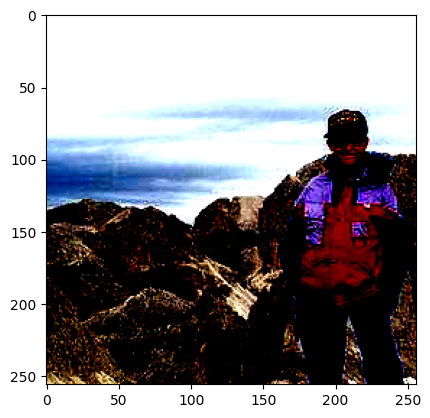

Starting Training Loop...
training epoch:  6


Training Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 6, Iteration: 4000, Loss: 7.779454231262207


Training Epoch 6:  32%|███▏      | 201/625 [06:18<13:22,  1.89s/it]

Epoch: 6, Iteration: 4200, Loss: 7.613955974578857


Training Epoch 6:  64%|██████▍   | 401/625 [12:33<07:04,  1.89s/it]

Epoch: 6, Iteration: 4400, Loss: 6.279873847961426


Training Epoch 6:  96%|█████████▌| 601/625 [18:48<00:45,  1.89s/it]

Epoch: 6, Iteration: 4600, Loss: 6.493478298187256


Training Epoch 6:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  7


Training Epoch 7:  30%|███       | 190/625 [05:56<13:44,  1.89s/it]

Epoch: 7, Iteration: 4800, Loss: 7.0139312744140625


Training Epoch 7:  62%|██████▏   | 390/625 [12:10<07:32,  1.92s/it]

Epoch: 7, Iteration: 5000, Loss: 7.175626754760742


Training Epoch 7:  94%|█████████▍| 590/625 [18:25<01:06,  1.89s/it]

Epoch: 7, Iteration: 5200, Loss: 6.500555038452148


Training Epoch 7:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  8


Training Epoch 8:  29%|██▊       | 179/625 [05:35<14:02,  1.89s/it]

Epoch: 8, Iteration: 5400, Loss: 6.6662397384643555


Training Epoch 8:  61%|██████    | 379/625 [11:50<07:46,  1.90s/it]

Epoch: 8, Iteration: 5600, Loss: 7.033718585968018


Training Epoch 8:  93%|█████████▎| 579/625 [18:05<01:27,  1.91s/it]

Epoch: 8, Iteration: 5800, Loss: 5.90203857421875


Training Epoch 8:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  9


Training Epoch 9:  27%|██▋       | 167/625 [05:12<14:14,  1.87s/it]

Epoch: 9, Iteration: 6000, Loss: 6.156786918640137


Training Epoch 9:  59%|█████▉    | 368/625 [11:30<08:08,  1.90s/it]

Epoch: 9, Iteration: 6200, Loss: 7.126438140869141


Training Epoch 9:  91%|█████████ | 568/625 [17:44<01:47,  1.89s/it]

Epoch: 9, Iteration: 6400, Loss: 6.2696027755737305


Training Epoch 9:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  10


Training Epoch 10:  25%|██▌       | 157/625 [04:54<14:47,  1.90s/it]

Epoch: 10, Iteration: 6600, Loss: 7.26952600479126


Training Epoch 10:  57%|█████▋    | 357/625 [11:08<08:25,  1.89s/it]

Epoch: 10, Iteration: 6800, Loss: 6.656375408172607


Training Epoch 10:  89%|████████▉ | 556/625 [17:21<02:09,  1.87s/it]

Epoch: 10, Iteration: 7000, Loss: 7.063556671142578


Training Epoch 10:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  11


Training Epoch 11:  23%|██▎       | 146/625 [04:33<15:14,  1.91s/it]

Epoch: 11, Iteration: 7200, Loss: 5.997176647186279


Training Epoch 11:  55%|█████▌    | 346/625 [10:49<08:52,  1.91s/it]

Epoch: 11, Iteration: 7400, Loss: 6.773879051208496


Training Epoch 11:  87%|████████▋ | 546/625 [17:04<02:30,  1.90s/it]

Epoch: 11, Iteration: 7600, Loss: 6.682547569274902


Training Epoch 11:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  12


Training Epoch 12:  22%|██▏       | 135/625 [04:12<15:23,  1.89s/it]

Epoch: 12, Iteration: 7800, Loss: 8.03518009185791


Training Epoch 12:  54%|█████▎    | 335/625 [10:27<09:25,  1.95s/it]

Epoch: 12, Iteration: 8000, Loss: 7.418841361999512


Training Epoch 12:  86%|████████▌ | 535/625 [16:41<02:50,  1.89s/it]

Epoch: 12, Iteration: 8200, Loss: 6.319355010986328


Training Epoch 12:  98%|█████████▊| 611/625 [19:03<00:26,  1.87s/it]


training epoch:  13


Training Epoch 13:  20%|█▉        | 124/625 [03:52<15:43,  1.88s/it]

Epoch: 13, Iteration: 8400, Loss: 7.01708984375


Training Epoch 13:  52%|█████▏    | 324/625 [10:06<09:30,  1.89s/it]

Epoch: 13, Iteration: 8600, Loss: 6.1666975021362305


Training Epoch 13:  84%|████████▍ | 524/625 [16:21<03:10,  1.89s/it]

Epoch: 13, Iteration: 8800, Loss: 6.4555888175964355


Training Epoch 13:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  14


Training Epoch 14:  18%|█▊        | 113/625 [03:32<16:37,  1.95s/it]

Epoch: 14, Iteration: 9000, Loss: 6.9722113609313965


Training Epoch 14:  50%|█████     | 313/625 [09:47<09:49,  1.89s/it]

Epoch: 14, Iteration: 9200, Loss: 6.086856842041016


Training Epoch 14:  82%|████████▏ | 513/625 [16:03<03:33,  1.90s/it]

Epoch: 14, Iteration: 9400, Loss: 6.453419208526611


Training Epoch 14:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  15


Training Epoch 15:  16%|█▋        | 102/625 [03:11<16:34,  1.90s/it]

Epoch: 15, Iteration: 9600, Loss: 6.041808128356934


Training Epoch 15:  48%|████▊     | 302/625 [09:26<10:14,  1.90s/it]

Epoch: 15, Iteration: 9800, Loss: 5.87227725982666


Training Epoch 15:  80%|████████  | 501/625 [15:39<03:51,  1.87s/it]

Epoch: 15, Iteration: 10000, Loss: 5.978744983673096


Training Epoch 15:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  16


Training Epoch 16:  15%|█▍        | 91/625 [02:50<16:49,  1.89s/it]

Epoch: 16, Iteration: 10200, Loss: 5.932950019836426


Training Epoch 16:  47%|████▋     | 291/625 [09:05<10:32,  1.89s/it]

Epoch: 16, Iteration: 10400, Loss: 6.315702438354492


Training Epoch 16:  79%|███████▊  | 491/625 [15:20<04:13,  1.89s/it]

Epoch: 16, Iteration: 10600, Loss: 5.699733257293701


Training Epoch 16:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  17


Training Epoch 17:  13%|█▎        | 80/625 [02:30<17:10,  1.89s/it]

Epoch: 17, Iteration: 10800, Loss: 6.547213554382324


Training Epoch 17:  45%|████▍     | 280/625 [08:46<11:12,  1.95s/it]

Epoch: 17, Iteration: 11000, Loss: 6.3981428146362305


Training Epoch 17:  77%|███████▋  | 480/625 [15:01<04:36,  1.90s/it]

Epoch: 17, Iteration: 11200, Loss: 5.890651226043701


Training Epoch 17:  98%|█████████▊| 611/625 [19:07<00:26,  1.88s/it]


training epoch:  18


Training Epoch 18:  11%|█         | 69/625 [02:09<17:40,  1.91s/it]

Epoch: 18, Iteration: 11400, Loss: 5.946530342102051


Training Epoch 18:  43%|████▎     | 269/625 [08:25<11:13,  1.89s/it]

Epoch: 18, Iteration: 11600, Loss: 6.123950958251953


Training Epoch 18:  75%|███████▌  | 469/625 [14:40<04:53,  1.88s/it]

Epoch: 18, Iteration: 11800, Loss: 6.185913562774658


Training Epoch 18:  98%|█████████▊| 611/625 [19:07<00:26,  1.88s/it]


training epoch:  19


Training Epoch 19:   9%|▉         | 58/625 [01:49<18:19,  1.94s/it]

Epoch: 19, Iteration: 12000, Loss: 5.600531578063965


Training Epoch 19:  41%|████▏     | 258/625 [08:04<11:34,  1.89s/it]

Epoch: 19, Iteration: 12200, Loss: 6.469805717468262


Training Epoch 19:  73%|███████▎  | 458/625 [14:19<05:17,  1.90s/it]

Epoch: 19, Iteration: 12400, Loss: 5.717430591583252


Training Epoch 19:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  20


Training Epoch 20:   8%|▊         | 47/625 [01:28<18:11,  1.89s/it]

Epoch: 20, Iteration: 12600, Loss: 5.760956287384033


Training Epoch 20:  40%|███▉      | 247/625 [07:43<11:54,  1.89s/it]

Epoch: 20, Iteration: 12800, Loss: 5.954568862915039


Training Epoch 20:  72%|███████▏  | 447/625 [13:58<05:46,  1.95s/it]

Epoch: 20, Iteration: 13000, Loss: 5.933431625366211


Training Epoch 20:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  21


Training Epoch 21:   6%|▌         | 36/625 [01:07<18:43,  1.91s/it]

Epoch: 21, Iteration: 13200, Loss: 6.0237555503845215


Training Epoch 21:  38%|███▊      | 236/625 [07:22<12:17,  1.90s/it]

Epoch: 21, Iteration: 13400, Loss: 5.49382209777832


Training Epoch 21:  70%|██████▉   | 436/625 [13:37<05:56,  1.89s/it]

Epoch: 21, Iteration: 13600, Loss: 6.681712627410889


Training Epoch 21:  98%|█████████▊| 611/625 [19:05<00:26,  1.88s/it]


training epoch:  22


Training Epoch 22:   4%|▍         | 25/625 [00:46<18:53,  1.89s/it]

Epoch: 22, Iteration: 13800, Loss: 5.394105911254883


Training Epoch 22:  36%|███▌      | 224/625 [06:59<12:27,  1.87s/it]

Epoch: 22, Iteration: 14000, Loss: 6.240472793579102


Training Epoch 22:  68%|██████▊   | 425/625 [13:17<06:23,  1.92s/it]

Epoch: 22, Iteration: 14200, Loss: 5.428651809692383


Training Epoch 22:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  23


Training Epoch 23:   2%|▏         | 14/625 [00:26<19:25,  1.91s/it]

Epoch: 23, Iteration: 14400, Loss: 5.771476745605469


Training Epoch 23:  34%|███▍      | 214/625 [06:41<12:54,  1.88s/it]

Epoch: 23, Iteration: 14600, Loss: 6.03269100189209


Training Epoch 23:  66%|██████▌   | 414/625 [12:57<06:38,  1.89s/it]

Epoch: 23, Iteration: 14800, Loss: 5.688670635223389


Training Epoch 23:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  24


Training Epoch 24:   0%|          | 3/625 [00:05<20:28,  1.97s/it]

Epoch: 24, Iteration: 15000, Loss: 5.197115898132324


Training Epoch 24:  32%|███▏      | 203/625 [06:21<13:21,  1.90s/it]

Epoch: 24, Iteration: 15200, Loss: 6.218232154846191


Training Epoch 24:  64%|██████▍   | 403/625 [12:36<07:03,  1.91s/it]

Epoch: 24, Iteration: 15400, Loss: 6.17962646484375


Training Epoch 24:  96%|█████████▋| 603/625 [18:51<00:41,  1.90s/it]

Epoch: 24, Iteration: 15600, Loss: 5.56288480758667


Training Epoch 24:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  25


Training Epoch 25:  31%|███       | 192/625 [06:00<13:40,  1.90s/it]

Epoch: 25, Iteration: 15800, Loss: 5.490146160125732


Training Epoch 25:  63%|██████▎   | 391/625 [12:13<07:18,  1.87s/it]

Epoch: 25, Iteration: 16000, Loss: 6.135409355163574


Training Epoch 25:  95%|█████████▍| 592/625 [18:30<01:02,  1.89s/it]

Epoch: 25, Iteration: 16200, Loss: 5.770147800445557


Training Epoch 25:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  26


Training Epoch 26:  29%|██▉       | 181/625 [05:39<13:59,  1.89s/it]

Epoch: 26, Iteration: 16400, Loss: 5.69944953918457


Training Epoch 26:  61%|██████    | 381/625 [11:54<07:39,  1.88s/it]

Epoch: 26, Iteration: 16600, Loss: 5.432331085205078


Training Epoch 26:  93%|█████████▎| 581/625 [18:09<01:23,  1.90s/it]

Epoch: 26, Iteration: 16800, Loss: 5.2367401123046875


Training Epoch 26:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  27


Training Epoch 27:  27%|██▋       | 169/625 [05:17<14:21,  1.89s/it]

Epoch: 27, Iteration: 17000, Loss: 6.27824592590332


Training Epoch 27:  59%|█████▉    | 370/625 [11:34<08:01,  1.89s/it]

Epoch: 27, Iteration: 17200, Loss: 6.045902252197266


Training Epoch 27:  91%|█████████ | 570/625 [17:49<01:43,  1.88s/it]

Epoch: 27, Iteration: 17400, Loss: 5.151262283325195


Training Epoch 27:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  28


Training Epoch 28:  25%|██▌       | 159/625 [04:58<14:42,  1.89s/it]

Epoch: 28, Iteration: 17600, Loss: 6.404932022094727


Training Epoch 28:  57%|█████▋    | 359/625 [11:13<08:22,  1.89s/it]

Epoch: 28, Iteration: 17800, Loss: 5.838663101196289


Training Epoch 28:  89%|████████▉ | 559/625 [17:28<02:08,  1.94s/it]

Epoch: 28, Iteration: 18000, Loss: 6.639861106872559


Training Epoch 28:  98%|█████████▊| 611/625 [19:06<00:26,  1.88s/it]


training epoch:  29


Training Epoch 29:  24%|██▎       | 148/625 [04:37<15:02,  1.89s/it]

Epoch: 29, Iteration: 18200, Loss: 7.371843338012695


Training Epoch 29:  56%|█████▌    | 348/625 [10:52<08:47,  1.90s/it]

Epoch: 29, Iteration: 18400, Loss: 5.954078197479248


Training Epoch 29:  88%|████████▊ | 548/625 [17:07<02:25,  1.89s/it]

Epoch: 29, Iteration: 18600, Loss: 6.104496955871582


Training Epoch 29:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  30


Training Epoch 30:  22%|██▏       | 137/625 [04:17<15:28,  1.90s/it]

Epoch: 30, Iteration: 18800, Loss: 5.561851501464844


Training Epoch 30:  54%|█████▍    | 337/625 [10:31<09:16,  1.93s/it]

Epoch: 30, Iteration: 19000, Loss: 5.859963893890381


Training Epoch 30:  86%|████████▌ | 537/625 [16:46<02:46,  1.89s/it]

Epoch: 30, Iteration: 19200, Loss: 5.692466735839844


Training Epoch 30:  98%|█████████▊| 611/625 [19:05<00:26,  1.87s/it]


training epoch:  31


Training Epoch 31:  20%|██        | 126/625 [03:56<15:38,  1.88s/it]

Epoch: 31, Iteration: 19400, Loss: 5.549826145172119


Training Epoch 31:  52%|█████▏    | 326/625 [10:11<09:25,  1.89s/it]

Epoch: 31, Iteration: 19600, Loss: 6.208248138427734


Training Epoch 31:  84%|████████▍ | 526/625 [16:25<03:06,  1.88s/it]

Epoch: 31, Iteration: 19800, Loss: 4.890878677368164


Training Epoch 31:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  32


Training Epoch 32:  18%|█▊        | 115/625 [03:35<16:30,  1.94s/it]

Epoch: 32, Iteration: 20000, Loss: 5.391304016113281


Training Epoch 32:  50%|█████     | 315/625 [09:50<09:43,  1.88s/it]

Epoch: 32, Iteration: 20200, Loss: 4.727985382080078


Training Epoch 32:  82%|████████▏ | 515/625 [16:04<03:27,  1.88s/it]

Epoch: 32, Iteration: 20400, Loss: 5.64390754699707


Training Epoch 32:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  33


Training Epoch 33:  17%|█▋        | 104/625 [03:14<16:26,  1.89s/it]

Epoch: 33, Iteration: 20600, Loss: 5.051721096038818


Training Epoch 33:  49%|████▊     | 304/625 [09:29<10:08,  1.90s/it]

Epoch: 33, Iteration: 20800, Loss: 5.615438461303711


Training Epoch 33:  81%|████████  | 504/625 [15:43<03:53,  1.93s/it]

Epoch: 33, Iteration: 21000, Loss: 5.6046366691589355


Training Epoch 33:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  34


Training Epoch 34:  15%|█▍        | 93/625 [02:54<16:56,  1.91s/it]

Epoch: 34, Iteration: 21200, Loss: 4.966973781585693


Training Epoch 34:  47%|████▋     | 293/625 [09:08<10:25,  1.88s/it]

Epoch: 34, Iteration: 21400, Loss: 5.641546249389648


Training Epoch 34:  79%|███████▉  | 493/625 [15:23<04:09,  1.89s/it]

Epoch: 34, Iteration: 21600, Loss: 5.274781227111816


Training Epoch 34:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  35


Training Epoch 35:  13%|█▎        | 82/625 [02:33<17:14,  1.91s/it]

Epoch: 35, Iteration: 21800, Loss: 6.339265823364258


Training Epoch 35:  45%|████▍     | 281/625 [08:46<10:41,  1.87s/it]

Epoch: 35, Iteration: 22000, Loss: 5.8711771965026855


Training Epoch 35:  77%|███████▋  | 482/625 [15:03<04:29,  1.88s/it]

Epoch: 35, Iteration: 22200, Loss: 5.005458831787109


Training Epoch 35:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  36


Training Epoch 36:  11%|█▏        | 71/625 [02:13<17:28,  1.89s/it]

Epoch: 36, Iteration: 22400, Loss: 5.234828948974609


Training Epoch 36:  43%|████▎     | 271/625 [08:28<11:15,  1.91s/it]

Epoch: 36, Iteration: 22600, Loss: 5.737947463989258


Training Epoch 36:  75%|███████▌  | 471/625 [14:42<04:51,  1.89s/it]

Epoch: 36, Iteration: 22800, Loss: 5.710577011108398


Training Epoch 36:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  37


Training Epoch 37:   9%|▉         | 59/625 [01:50<17:39,  1.87s/it]

Epoch: 37, Iteration: 23000, Loss: 5.633466720581055


Training Epoch 37:  42%|████▏     | 260/625 [08:07<11:27,  1.88s/it]

Epoch: 37, Iteration: 23200, Loss: 4.610074043273926


Training Epoch 37:  74%|███████▎  | 460/625 [14:21<05:10,  1.88s/it]

Epoch: 37, Iteration: 23400, Loss: 5.476279258728027


Training Epoch 37:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  38


Training Epoch 38:   8%|▊         | 49/625 [01:31<18:08,  1.89s/it]

Epoch: 38, Iteration: 23600, Loss: 5.620490074157715


Training Epoch 38:  40%|███▉      | 249/625 [07:46<11:50,  1.89s/it]

Epoch: 38, Iteration: 23800, Loss: 5.321342468261719


Training Epoch 38:  72%|███████▏  | 449/625 [14:00<05:41,  1.94s/it]

Epoch: 38, Iteration: 24000, Loss: 5.147841453552246


Training Epoch 38:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  39


Training Epoch 39:   6%|▌         | 38/625 [01:11<18:25,  1.88s/it]

Epoch: 39, Iteration: 24200, Loss: 5.187779903411865


Training Epoch 39:  38%|███▊      | 238/625 [07:26<12:09,  1.88s/it]

Epoch: 39, Iteration: 24400, Loss: 5.227729797363281


Training Epoch 39:  70%|███████   | 438/625 [13:41<05:57,  1.91s/it]

Epoch: 39, Iteration: 24600, Loss: 5.5144171714782715


Training Epoch 39:  98%|█████████▊| 611/625 [19:05<00:26,  1.88s/it]


training epoch:  40


Training Epoch 40:   4%|▍         | 27/625 [00:50<18:50,  1.89s/it]

Epoch: 40, Iteration: 24800, Loss: 5.733924865722656


Training Epoch 40:  36%|███▋      | 227/625 [07:05<12:51,  1.94s/it]

Epoch: 40, Iteration: 25000, Loss: 5.047883033752441


Training Epoch 40:  68%|██████▊   | 427/625 [13:20<06:15,  1.89s/it]

Epoch: 40, Iteration: 25200, Loss: 6.005544662475586


Training Epoch 40:  98%|█████████▊| 611/625 [19:04<00:26,  1.87s/it]


training epoch:  41


Training Epoch 41:   3%|▎         | 16/625 [00:30<19:22,  1.91s/it]

Epoch: 41, Iteration: 25400, Loss: 5.154298305511475


Training Epoch 41:  35%|███▍      | 216/625 [06:45<12:58,  1.90s/it]

Epoch: 41, Iteration: 25600, Loss: 4.772166728973389


Training Epoch 41:  42%|████▏     | 260/625 [08:09<11:27,  1.88s/it]


KeyboardInterrupt: 

In [ ]:
train()

Andersson Weight 로 돌리고 나서 , generator 가 잘 작동하는지 실제 image를 넣어  test 해보기

1. train() , pretrain() 셀 과 이 ipynb 의 마지막 셀 빼고 모두 실행하고<br>
2. 이 텍스트 바로 위의 코드를 실행 한 후에 ( andersson 의 weight 를 가져와서 이어서 D, G를 100 epoch 으로 학습하는 방법 )  
3. 이 ipynb 의 마지막 셀의 코드를 돌려서 generator 가 잘 작동하는지 실제 image 를 넣어 test 해보기

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                  padding=0, bias=False)
    )


class ShuffleUpBlock(nn.Module):
    def __init__(self, scale=2, add_blur=False):
        super(UpBlock, self).__init__()

        self.shuffle = nn.PixelShuffle(scale)
        self.has_blur = add_blur
        if self.has_blur:
            self.blur = nn.AvgPool2d(2, 1)

    def forward(self, x):
        if self.has_blur:
            x = self.blur(x)
        x = self.shuffle(x)
        return x


class Self_Attn(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_dim, activation):
        super(Self_Attn, self).__init__()
        self.chanel_in = in_dim
        self.activation = activation

        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(
            m_batchsize, -1, width*height).permute(0, 2, 1)  # B X CX(N)
        proj_key = self.key_conv(x).view(
            m_batchsize, -1, width*height)  # B X C x (*W*H)
        energy = torch.bmm(proj_query, proj_key)  # transpose check
        attention = self.softmax(energy)  # BX (N) X (N)
        proj_value = self.value_conv(x).view(
            m_batchsize, -1, width*height)  # B X C X N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma*out + x
        return out, attention


class UpBlock(nn.Module):
    def __init__(self, in_f, out_f, stride=2, add_blur=False):
        super(UpBlock, self).__init__()

        self.shuffle = nn.ConvTranspose2d(
            in_f, out_f, kernel_size=3, stride=stride, padding=0)
        self.has_blur = add_blur
        if self.has_blur:
            self.blur = nn.AvgPool2d(2, 1)

    def forward(self, x):
        x = self.shuffle(x)
        if self.has_blur:
            x = self.blur(x)
        return x


def add_resblocks(channel_num, nr_blocks):
    return nn.Sequential(*[ResBlock(channel_num) for i in range(nr_blocks)])


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(inplace=True),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
NEG_SLOPE = .2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv = nn.Sequential(
            conv3x3(3, 32, stride=1),
            nn.LeakyReLU(NEG_SLOPE, inplace=True),

            conv3x3(32, 64, stride=2),
            nn.LeakyReLU(NEG_SLOPE, inplace=True),
            conv3x3(64, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(NEG_SLOPE, inplace=True),

            conv3x3(128, 128, stride=2),
            nn.LeakyReLU(NEG_SLOPE, inplace=True),
            conv3x3(128, 256, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(NEG_SLOPE, inplace=True),

            conv3x3(256, 1, stride=1),  # ??
            nn.Sigmoid()  # ??
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.down = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1,
                      padding=7//2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            conv3x3(64, 128, stride=2),
            conv3x3(128, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            conv3x3(128, 256, stride=2),
            conv3x3(256, 256, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.res = nn.Sequential(add_resblocks(256, 8))

        self.up = nn.Sequential(
            UpBlock(256, 128, stride=2, add_blur=True),
            conv3x3(128, 128, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            UpBlock(128, 64, stride=2, add_blur=True),
            conv3x3(64, 64, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=7//2)
        )

    def forward(self, x):
        x = self.down(x)
        x = self.res(x)
        x = self.up(x)
        return x

In [ ]:
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

D = Discriminator().to(device)
G = Generator().to(device)

G.load_state_dict(
    torch.load
    ("/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G/G_epoch47_iter29000_loss4.274.pth"))


D.load_state_dict(
    torch.load("/content/drive/MyDrive/GAN/CartoonGAN/checkpoints/train_D_G/D_epoch47_iter29000_loss1.700.pth"))


# 이미지 생성 및 저장
output_dir = '/content/transformed_images'
os.makedirs(output_dir, exist_ok=True)

# 데이터셋 및 데이터로더 설정
data_loader = get_dataloader(real_data_path, size=256, batch_size=16)


G.eval()
with torch.no_grad():
    for i, images in enumerate(tqdm(data_loader, desc='Transforming Images')):
        images = images.to(device)
        transformed_images = unnormalize(G(images))
        for j, image in enumerate(transformed_images):
            save_image(image, os.path.join(output_dir, f'transformed_image_{i*len(images)+j}.png'))
